### This notebook is suitable for model training on datasets after preprocessing (e.g. `clr-1`) e.g. models, once trained, are dataset-specific and cannot be evaluated on different datasets

In [1]:
import os
import sys
import joblib
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

In [2]:
MODULE_PATH = os.path.abspath('/storage/pszczerbiak/microbiome_interactions_project/')  # TODO load from CONFIG file
if MODULE_PATH not in sys.path:
    sys.path.append(MODULE_PATH)

In [3]:
from utils.transformers import inverse_through_timesteps_wrapper
from utils.train_test import series_to_supervised, split_reframed, prepare_sequential_data, prepare_supervised_data
from models.baseline import sequential_mlp, supervised_mlp, SupervisedMLP, SequentialMLP
from models.baseline_with_diff import SupervisedDiffMLP, SequentialDiffMLP
from models.baseline_with_attention import SupervisedAttentionMLP, supervised_attention_mlp
from utils.evaluate import calculate_measures, plot_series

## Load data

In [4]:
dname = 'donorA'  # dataset name

# PREPROCESSING
filtername = 'filtered-0.9'
sname = 'clr-1-True'
DATA_PATH = Path("/storage/zkarwowska/microbiome-interactions/datasets/processed/ready_datasets_preprocessed/")  # TODO load from CONFIG file
dataset = pd.read_csv(DATA_PATH / "filtered_transformed/" / f"{dname}_{filtername}_{sname}.csv", index_col=0)
dataset_original = pd.read_csv(DATA_PATH / "filtered" / f"{dname}_{filtername}.csv", index_col=0)
scaler = joblib.load(DATA_PATH / f'scaler_{dname}_{filtername}_{sname}.obj')

#### Additional parameters for `scaler.inverse_transform()`

For `clr` transformations we don't want to remove pseudocounts since it requires knowledge where initial 0's are located (there are not always known)

In [5]:
sparams = {'remove_pseudocounts': False} if 'clr' in sname else {}

#### Reference dataset may have different number of rows but the same number of columns

In [6]:
dataset.shape, dataset_original.shape

((365, 205), (365, 205))

In [7]:
assert dataset.shape == dataset_original.shape

## Plot data

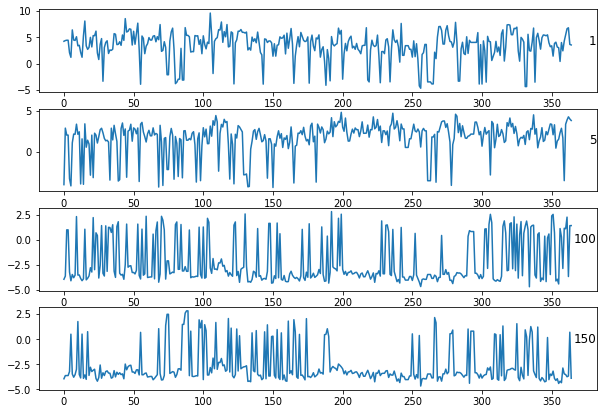

In [8]:
columns = [1, 5, 100, 150]
plt.figure(figsize=(10, 7))
for i, column in enumerate(columns):
    plt.subplot(len(columns), 1, i+1)
    plt.plot(dataset.iloc[:, column])
    # plt.plot(dataset_original.iloc[:, column])
    plt.title(column, y=0.5, loc='right')
plt.show()

## Data Preparation

The first step is to prepare the dataset for ML predictions. This involves framing the dataset as a supervised learning problem and normalizing the input variables (already done above).

### Convert series to supervised learning

**Assumption**  
We believe that predicitions in subsequent time step depend on values from **the last `STEPS_IN` time steps only**. 

Therefore:  

Number of samples = `dataset.shape[0] // STEPS_IN` (we need to throw last couple of timesteps)  
Number of input timesteps = `STEPS_IN`  
Number of output timesteps = `STEPS_OUT`  
Number of input features = `dataset.shape[1]`  
Number of output features = `dataset.shape[1]`

In [9]:
STEPS_IN = 2
STEPS_OUT = 1

In [10]:
reframed = series_to_supervised(dataset.values, STEPS_IN, STEPS_OUT)

In [11]:
dataset.shape, reframed.shape

((365, 205), (363, 615))

In [12]:
reframed

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),...,var196(t),var197(t),var198(t),var199(t),var200(t),var201(t),var202(t),var203(t),var204(t),var205(t)
2,0.659653,4.243172,4.060851,1.352801,-3.945517,-3.945517,2.269091,-3.945517,-3.945517,0.659653,...,-3.626044,-3.626044,-3.626044,-3.626044,-3.626044,-3.626044,-3.626044,-3.626044,-3.626044,-3.626044
3,2.075917,4.378502,4.112799,3.375200,0.977304,2.923214,3.174529,-3.627866,-3.627866,-3.627866,...,-3.626044,-3.626044,-3.626044,-3.626044,-3.626044,-3.626044,-3.626044,-3.626044,-3.626044,-3.626044
4,-3.626044,4.444862,4.198002,2.588564,-3.626044,2.077738,3.176350,-3.626044,-3.626044,1.672273,...,-3.223828,-3.223828,-3.223828,-3.223828,-3.223828,-3.223828,-3.223828,-3.223828,-3.223828,-3.223828
5,-3.626044,4.444862,4.198002,2.588564,-3.626044,2.077738,3.176350,-3.626044,-3.626044,1.672273,...,-4.097429,-4.097429,-4.097429,-4.097429,-4.097429,-4.097429,-4.097429,-4.097429,-4.097429,-4.097429
6,1.381343,2.074490,2.767637,3.578567,-3.223828,-3.223828,2.990781,-3.223828,-3.223828,-3.223828,...,-3.470275,-3.470275,-3.470275,-3.470275,-3.470275,-3.470275,-3.470275,-3.470275,-3.470275,-3.470275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,-2.871301,2.427016,4.372926,3.813310,-2.871301,1.733869,3.343307,-2.871301,1.733869,1.733869,...,3.483176,-3.519889,3.857870,-3.519889,-3.519889,-3.519889,-3.519889,-3.519889,-3.519889,-3.519889
361,-3.462558,4.278107,1.142613,1.835760,-3.462558,-3.462558,-3.462558,-3.462558,-3.462558,-3.462558,...,-3.743021,-3.743021,-3.743021,-3.743021,-3.743021,-3.743021,-3.743021,-3.743021,-3.743021,-3.743021
362,2.471575,5.454729,3.724338,5.074265,1.085281,3.387866,2.471575,1.778428,-3.519889,1.085281,...,-3.674078,-3.674078,-3.674078,-3.674078,-3.674078,-3.674078,-3.674078,-3.674078,-3.674078,-3.674078
363,-3.743021,6.624200,3.752520,6.060646,1.960761,3.906671,3.347055,0.862149,2.248443,0.862149,...,-3.900109,-3.900109,-3.900109,-3.900109,-3.900109,-3.900109,-3.900109,-3.900109,-3.900109,-3.900109


### Split data into train and test sets

In [13]:
TRAIN_TEST_SPLIT = 0.8
OVERLAP = True
SHUFFLE = False

In [14]:
train_X, train_y, test_X, test_y, \
train_indices_y, test_indices_y = split_reframed(reframed, len(dataset.columns), TRAIN_TEST_SPLIT, 
                                                 STEPS_IN, overlap=OVERLAP, shuffle=SHUFFLE, return_indices=True)

If the dataset is small, we could replicate the data by performing moving slicies (e.g. using `np.vstack()` see [here](https://stackoverflow.com/questions/15722324/sliding-window-of-m-by-n-shape-numpy-ndarray)).

Doing so, in our example we could get large input dataset.

---
## ALL ABOVE IS THE SAME FOR BOTH KERAS AND PYTORCH

---

## Define and fit models

### Sequential
- We will define `in_features` independent multi-headed MLP with `in_steps` neurons in the first hidden layer, concatenate them and return `out_features` predictions.
- The input shape will be `in_steps` time steps with `in_features` features.
- We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.

### Supervised
- We will define one-headed MLP with `in_steps x in_features` inputs and one hidden layer with `out_features` predictions.
- Therefore, it is purely a supervised model.
- We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.

In [15]:
in_steps = train_X.shape[1]
in_features = train_X.shape[2]
out_features = train_y.shape[1]

In [16]:
assert in_steps == STEPS_IN
assert in_features == dataset.shape[1]
assert out_features == dataset.shape[1] * STEPS_OUT

In [17]:
train_X_seq, test_X_seq = prepare_sequential_data(train_X, test_X, in_features)
train_X_super, test_X_super = prepare_supervised_data(train_X, test_X, order='F')

#### Differencing (demo #2) (suitable for `in_steps = 2`)

In [18]:
# Differencing for supervised input
# each row corresponds to one timestep
# each column corresponds to one bacterium
# train_X_super_diff = train_X_super[:,in_features:] - train_X_super[:,:in_features]

In [19]:
# Differencing for sequential input
# for each element of the list (bacterium)
# each cell correspond to one timestep 
# train_X_seq_diff = train_X_seq[0][:,1] - train_X_seq[0][:,0]

### Declare parameters

#### If the data includes negative values, use linear activation in the last layer 

In [20]:
pred_activation = 'linear' if train_X.min() < 0 else 'relu'

In [21]:
kwargs_super = {'pred_activation': pred_activation, 'use_bias': True, 'L1': 0.0001, 'L2': 0.0001}
kwargs_seq = {'pred_activation': pred_activation, 'input_activation': 'relu', 
'use_input_bias': True, 'use_pred_bias': True, 'input_L1': 0.001, 'input_L2': 0.001, 'pred_L1': 0.0001, 'pred_L2': 0.0001}

### Standard MLP

In [22]:
# model_supervised = supervised_mlp(in_steps, in_features, out_features, **kwargs_super)
# model_sequential = sequential_mlp(in_steps, in_features, out_features,  **kwargs_seq)
# or using subclass API
# model_supervised = SupervisedMLP(in_steps, in_features, out_features, **kwargs_super)
# model_supervised.compile(optimizer='adam', loss='mae')
# model_sequential = SequentialMLP(in_steps, in_features, out_features, **kwargs_seq)
# model_sequential.compile(optimizer='adam', loss='mae')

### With attention
#### Doesn't work in the current version i.e. attention context is not fully utilized in the training process...

In [23]:
# model_supervised = supervised_attention_mlp(in_steps, in_features, out_features, **kwargs_super)
# model_supervised.summary()
## Or:
# model_supervised = SupervisedAttentionMLP(in_steps, in_features, out_features, **kwargs_super)
# model_supervised.compile(optimizer='adam', loss='mae')

### With differencing

In [24]:
model_supervised = SupervisedDiffMLP(in_steps, in_features, out_features, **kwargs_super)
model_supervised.compile(optimizer='adam', loss='mae')
model_sequential = SequentialDiffMLP(in_steps, in_features, out_features, **kwargs_seq)
model_sequential.compile(optimizer='adam', loss='mae')

2022-08-18 14:36:39.220905: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-18 14:36:39.223338: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


### Fit models

2022-08-18 14:36:39.421266: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


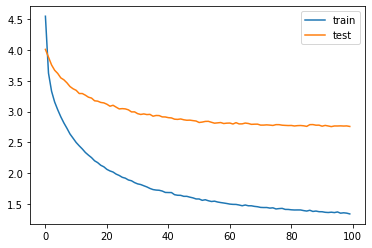

In [25]:
history = model_supervised.fit(train_X_super, train_y, epochs=100, batch_size=16, 
                    validation_data=(test_X_super, test_y), verbose=0, shuffle=True)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

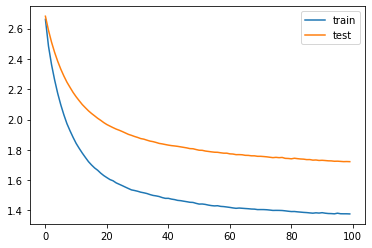

In [26]:
history = model_sequential.fit(train_X_seq, train_y, epochs=100, batch_size=16, 
                    validation_data=(test_X_seq, test_y), verbose=0, shuffle=True)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Evaluate models

- Evaluation doesn't work for `STEPS_OUT > 1`  
- Naive predictor doesn't work for `STEPS_OUT > 1`

But, both issues can be easily fixed (if needed).

### Naive predictions

Note that we can't use naive predictiors here - preprocessing transformer couldn't make an inverse transform in such case

In [27]:
columns_dict = dict(zip(dataset_original, range(0, dataset_original.shape[1])))
train_inv_ynaive = dataset_original.loc[train_indices_y - 1].rename(columns=columns_dict).set_index(train_indices_y)
test_inv_ynaive = dataset_original.loc[test_indices_y - 1].rename(columns=columns_dict).set_index(test_indices_y)

In [28]:
columns_dict = dict(zip(dataset, range(0, dataset.shape[1])))
train_ynaive = dataset.loc[train_indices_y - 1].rename(columns=columns_dict).set_index(train_indices_y)
test_ynaive = dataset.loc[test_indices_y - 1].rename(columns=columns_dict).set_index(test_indices_y)

### Models' predictions

In [29]:
train_yhat_super = model_supervised.predict(train_X_super)
test_yhat_super = model_supervised.predict(test_X_super)
train_yhat_seq = model_sequential.predict(train_X_seq)
test_yhat_seq = model_sequential.predict(test_X_seq)

### Inverse transform

Note: it's dataset dependent

In [30]:
train_inv_y, test_inv_y = inverse_through_timesteps_wrapper(scaler, dataset, 
                          [{'data': train_y, 'index': train_indices_y}, 
                           {'data': test_y, 'index': test_indices_y}], sparams)
train_inv_yhat_super, test_inv_yhat_super = inverse_through_timesteps_wrapper(scaler, dataset, 
                          [{'data': train_yhat_super, 'index': train_indices_y}, 
                           {'data': test_yhat_super, 'index': test_indices_y}], sparams)
train_inv_yhat_seq, test_inv_yhat_seq = inverse_through_timesteps_wrapper(scaler, dataset, 
                          [{'data': train_yhat_seq, 'index': train_indices_y}, 
                           {'data': test_yhat_seq, 'index': test_indices_y}], sparams)

### Scores

In [31]:
scores_train_naive = calculate_measures(train_inv_y, train_inv_ynaive)
scores_test_naive = calculate_measures(test_inv_y, test_inv_ynaive)

/home/MCB/pszczerbiak/miniconda3/envs/keras/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.44717258244537333 and the largest is 9.84814358351101.
  warn(
/home/MCB/pszczerbiak/miniconda3/envs/keras/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for

In [32]:
scores_train_super = calculate_measures(train_inv_y, train_inv_yhat_super)
scores_test_super = calculate_measures(test_inv_y, test_inv_yhat_super)
scores_train_seq = calculate_measures(train_inv_y, train_inv_yhat_seq)
scores_test_seq = calculate_measures(test_inv_y, test_inv_yhat_seq)

/home/MCB/pszczerbiak/miniconda3/envs/keras/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.44717258244537333 and the largest is 9.84814358351101.
  warn(
/home/MCB/pszczerbiak/miniconda3/envs/keras/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for

In [33]:
"Super, train:", scores_train_super, "Super, train (naive):", scores_train_naive

('Super, train:',
 {'f1score': (1.0, 0.0),
  'spearman': (0.4852914224968114, 0.19332072141750503, 0),
  'nrmse': (0.5227295390251047, 0.8613611677355304, 0),
  'inter': (0.425985537500267, 0.1484746605514077),
  'intra': 0.7308596505356361},
 'Super, train (naive):',
 {'f1score': (0.6438860792279494, 0.06377126952652262),
  'spearman': (0.39360401643989706, 0.20837418471155067, 0),
  'nrmse': (0.14215483529767123, 0.04267480004263432, 0),
  'inter': (0.23583677951360127, 0.14820173623024158),
  'intra': 0.6584813091051669})

In [34]:
"Super, test:", scores_test_super, "Super, test (naive):", scores_test_naive

('Super, test:',
 {'f1score': (1.0, 0.0),
  'spearman': (0.13773245865953193, 0.09740071026558338, 0),
  'nrmse': (9.159965596847101, 26.908977285276876, 6),
  'inter': (0.8100359649245148, 0.11546411676396333),
  'intra': 0.7828054509302461},
 'Super, test (naive):',
 {'f1score': (0.6724251083601901, 0.06511610981422963),
  'spearman': (0.27563317986788965, 0.15722009484768068, 12),
  'nrmse': (0.22093861329447903, 0.07571442101229735, 0),
  'inter': (0.25622751295055957, 0.13316521040051787),
  'intra': 0.7744096018375451})

In [35]:
"Seq, train:", scores_train_seq, "Seq, train (naive):", scores_train_naive

('Seq, train:',
 {'f1score': (1.0, 0.0),
  'spearman': (0.4465413505289825, 0.21943578433901015, 0),
  'nrmse': (0.1377715910391876, 0.0475427056118007, 0),
  'inter': (0.22088611542312495, 0.13331232338328836),
  'intra': 0.5778275131750783},
 'Seq, train (naive):',
 {'f1score': (0.6438860792279494, 0.06377126952652262),
  'spearman': (0.39360401643989706, 0.20837418471155067, 0),
  'nrmse': (0.14215483529767123, 0.04267480004263432, 0),
  'inter': (0.23583677951360127, 0.14820173623024158),
  'intra': 0.6584813091051669})

In [36]:
"Seq, test:", scores_test_seq, "Seq, test (naive):", scores_test_naive

('Seq, test:',
 {'f1score': (1.0, 0.0),
  'spearman': (0.25515831069493583, 0.15918617300413002, 0),
  'nrmse': (0.2845677834982064, 0.16281394643280353, 0),
  'inter': (0.34130186161387716, 0.14128436603791839),
  'intra': 0.7791634924844633},
 'Seq, test (naive):',
 {'f1score': (0.6724251083601901, 0.06511610981422963),
  'spearman': (0.27563317986788965, 0.15722009484768068, 12),
  'nrmse': (0.22093861329447903, 0.07571442101229735, 0),
  'inter': (0.25622751295055957, 0.13316521040051787),
  'intra': 0.7744096018375451})

### Plots - supervised

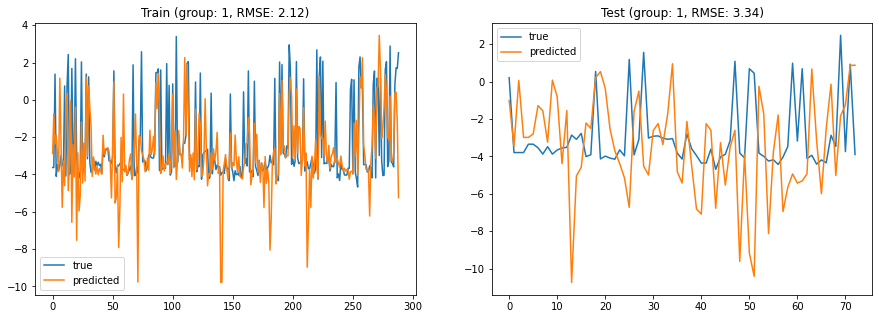

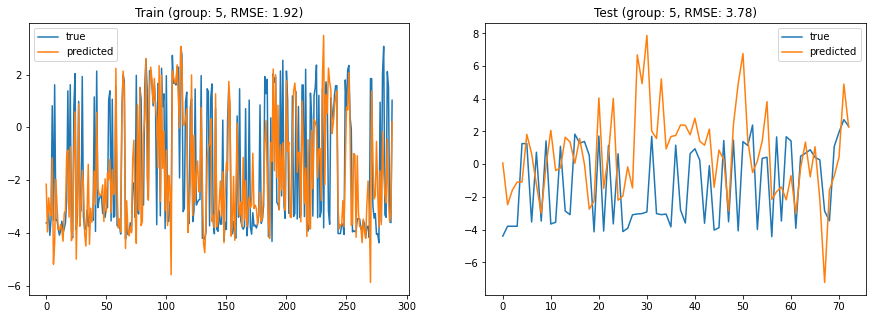

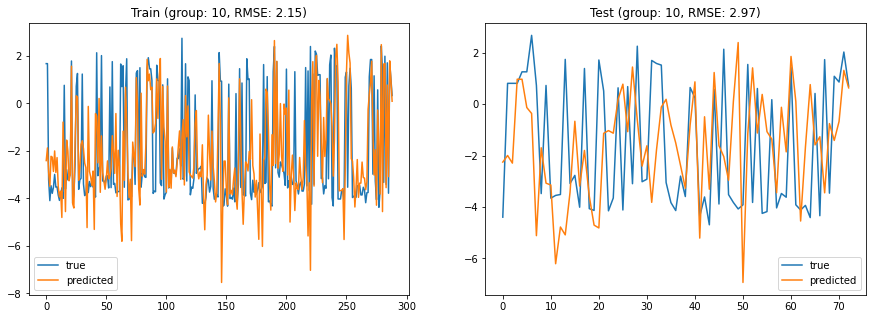

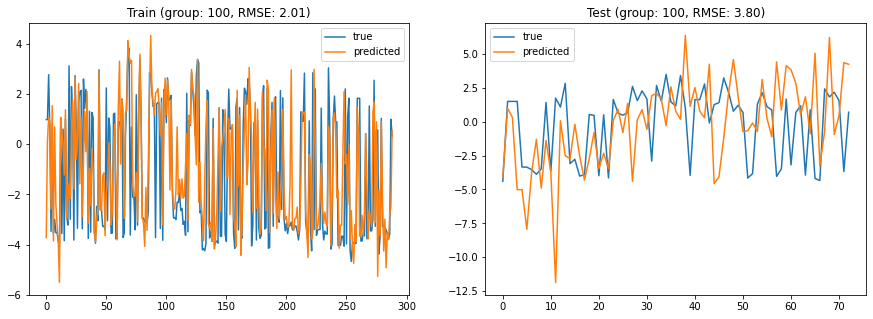

In [37]:
for group in [1, 5, 10, 100]:
    plot_series(pd.DataFrame(train_y), pd.DataFrame(train_yhat_super), None, 
                pd.DataFrame(test_y), pd.DataFrame(test_yhat_super), None, group)

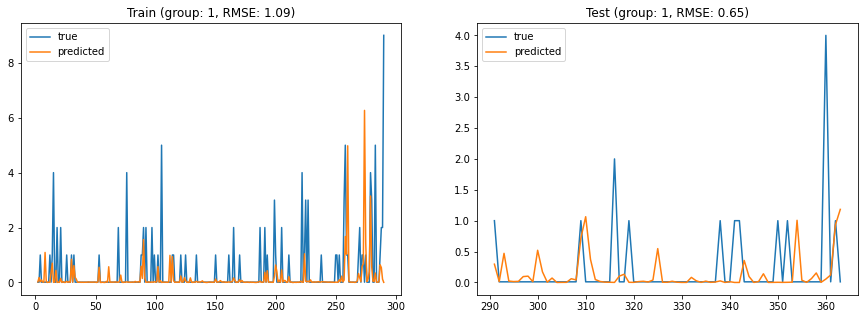

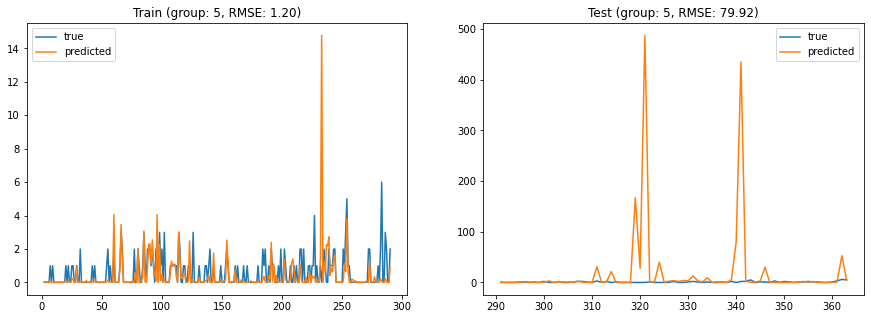

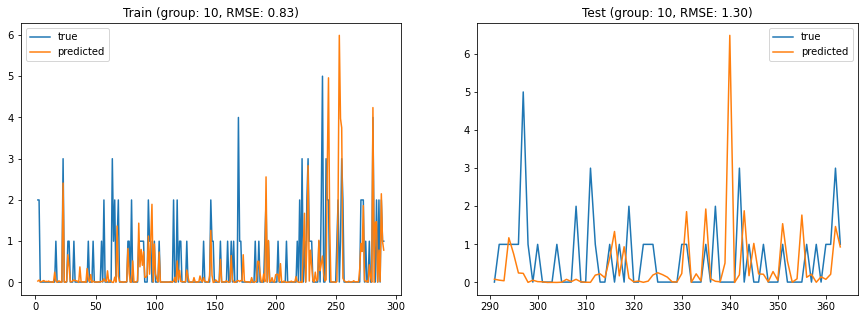

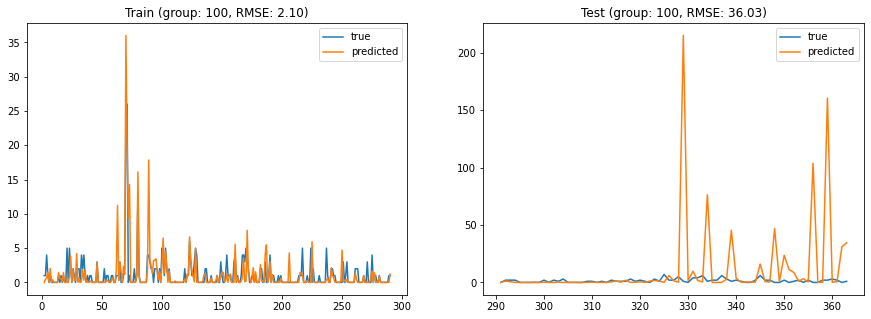

In [38]:
for group in [1, 5, 10, 100]:
    plot_series(train_inv_y.sort_index(), train_inv_yhat_super.sort_index(), None, 
                test_inv_y.sort_index(), test_inv_yhat_super.sort_index(), None, group)

### Plots - sequential

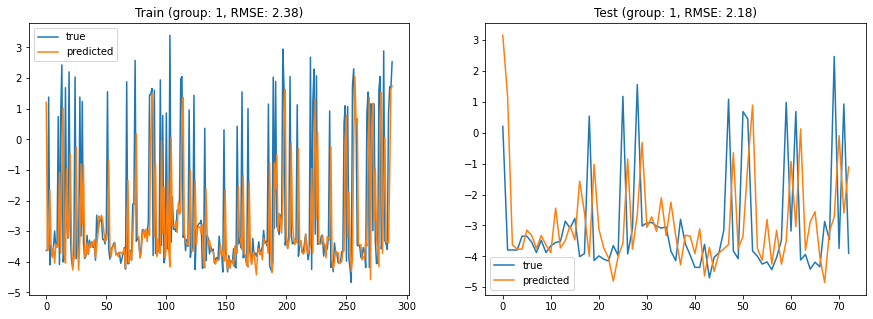

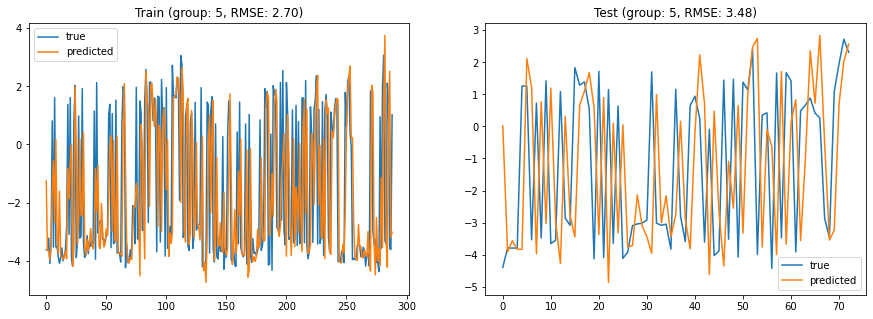

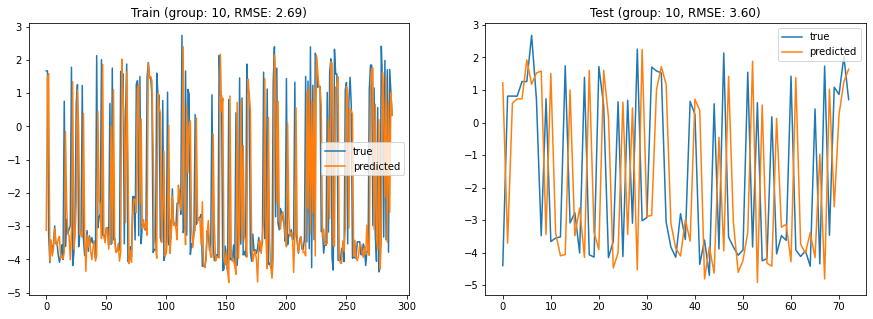

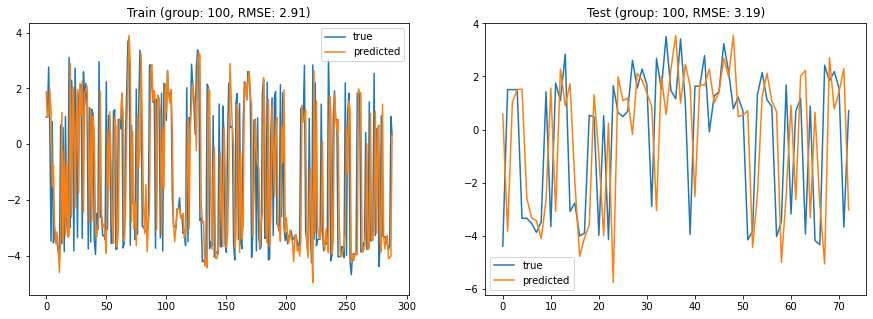

In [39]:
for group in [1, 5, 10, 100]:
    plot_series(pd.DataFrame(train_y), pd.DataFrame(train_yhat_seq), None, 
                pd.DataFrame(test_y), pd.DataFrame(test_yhat_seq), None, group)

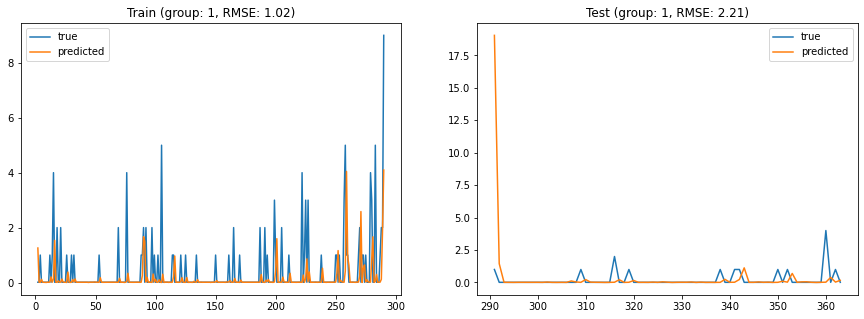

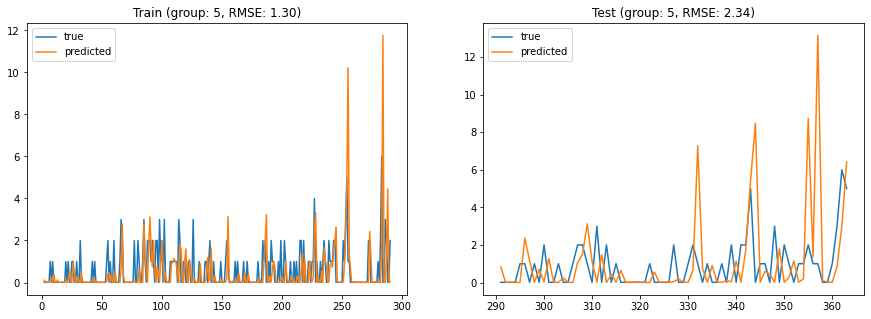

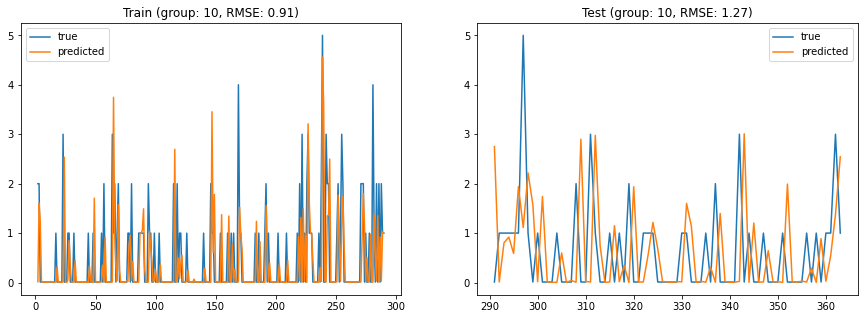

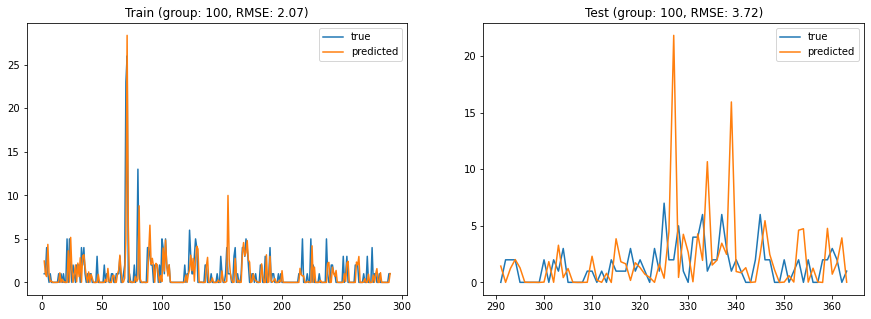

In [40]:
for group in [1, 5, 10, 100]:
    plot_series(train_inv_y.sort_index(), train_inv_yhat_seq.sort_index(), None, 
                test_inv_y.sort_index(), test_inv_yhat_seq.sort_index(), None, group)

## Verify predictions with the ones generated in pipeline 

In [41]:
names = ['supervised']
pars = ["_".join([f"{k}={v}" for k, v in kwargs_super.items()][1:]),
        "_".join([f"{k}={v}" for k, v in kwargs_seq.items()][2:])]

if not SHUFFLE:
    for i in range(len(names)):
        path = Path(MODULE_PATH) / "pipelines" / "dataset_specific" / "results" / "baseline_diff" /\
        f"mlp-diff_{names[i]}_id_{dname}_{filtername}_{sname}_overlap={OVERLAP}_shuffle=False_{pars[i]}"
        train_val_pred = np.load(path / "train_val_predictions.npz")
        # grand true
        assert (train_val_pred['counts_val_y'] == test_inv_y.values).all()
        assert (train_val_pred['counts_train_y'] == train_inv_y.values).all()
        # naive
        assert (train_val_pred['counts_val_ynaive'] == test_inv_ynaive.values).all()
        assert (train_val_pred['counts_train_ynaive'] == train_inv_ynaive.values).all()
        # measures
        scores_train_counts = json.load(open(path / 'scores' / f'counts_train_ynaive.json', 'r'))
        scores_val_counts = json.load(open(path / 'scores' / f'counts_val_ynaive.json', 'r'))
        scores_train_trans = json.load(open(path / 'scores' / f'trans_train_ynaive.json', 'r'))
        scores_val_trans = json.load(open(path / 'scores' / f'trans_val_ynaive.json', 'r'))
        scores_train_counts_nb = calculate_measures(train_inv_ynaive, train_inv_y)
        scores_val_counts_nb = calculate_measures(test_inv_ynaive, test_inv_y)
        scores_train_trans_nb = calculate_measures(train_ynaive, train_y)
        scores_val_trans_nb = calculate_measures(test_ynaive, test_y)
        assert scores_train_counts.keys() == scores_val_counts.keys() == scores_train_trans.keys() == scores_val_trans.keys() == \
        scores_train_counts_nb.keys() == scores_val_counts_nb.keys() == scores_train_trans_nb.keys() == scores_val_trans_nb.keys() == \
        {'f1score', 'spearman', 'nrmse', 'inter', 'intra'}
        for k in ['f1score', 'spearman', 'nrmse', 'inter']:
            scores_train_counts[k] == list(scores_train_counts_nb[k])
            scores_val_counts[k] == list(scores_val_counts_nb[k])
            scores_train_trans[k] == list(scores_train_trans_nb[k])
            scores_val_trans[k] == list(scores_val_trans_nb[k])
        scores_train_counts['inter'] == scores_train_counts_nb['inter']
        scores_val_counts['inter'] == scores_val_counts_nb['inter']
        scores_train_trans['inter'] == scores_train_trans_nb['inter']
        scores_val_trans['inter'] == scores_val_trans_nb['inter']

/home/MCB/pszczerbiak/miniconda3/envs/keras/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.44148080942922874 and the largest is 9.855857297324228.
  warn(
/home/MCB/pszczerbiak/miniconda3/envs/keras/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section fo